In [385]:
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler
import dataframe_image as dfi
import matplotlib.pyplot as plt
plt.style.use('ggplot')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [386]:
## Constants
# Ambient Conditions
h = 0  # km
P_a = 101326  # N/m^2 (std)
T_a = 288.15  # K (std)
a_a = 340.3  # m/s (std)
rho_a = 1.225  # kg/m^3

# Universal Constanrs
R = 287  # J/kg-K
gamma_c = 1.4
gamma_h = 1.333
cpa = 1.005 * 1000  # J/kg-K
cpg = 1.148 * 1000  # J/kg-K

# Operating Conditions
M_0 = 0

## Specifications
# General
mdot_a = 520  # kg/s

# Fan
BPR = 7.0
pi_f = 1.6
eta_pf = 0.91

# Compressor
eta_pc = 0.9  # MINIMUM
pi_c = 18.0

# Turbine
TIT = 2150  # K
eta_pt = 0.93
phi_t = 0.75  # MINIMUM
psi_t = 3.0  # MAXIMUM

# Criterion
DE_HALLER_MIN = 0.65
TIP_MACH_MAX = 1.2

## Preliminary Calculations
mdot_h = mdot_a/(BPR+1)
mdot_c = (mdot_a*BPR)/(BPR+1)

In [387]:
## Variables
C_a = 200 # 150  # m/s [150, 200]
t_h_rat = 0.5 # 0.3  # [0, 1]
M_tip = 1.2 # 1.1  # [0, 1.2]
lam = 1
dehaller = 0.7 # 0.764
lambd = [0.97, 0.95, 0.92, 0.905, 0.895, 0.875, 0.867, 0.86, 0.855, 0.85, 0.849, 0.848, 0.847, 0.846, 0.8455, 0.845, 0.8449, 0.8448, 0.8447, 0.8446] #Mean Work Done Factor based on stage

In [388]:
## Initial Conditions
T_t1 = T_a
P_t1 = P_a


T_1 = T_t1 - ((C_a**2)/(2*cpa))
P_1 = P_t1*((T_1/T_t1)**(gamma_c/(gamma_c-1)))
rho_1 = P_1/(R*T_1)
a_1 = np.sqrt(gamma_c*R*T_1)

## Fan
P_t2 = P_t1*pi_f
T_t2 = T_t1 + T_t1*((pi_f**((gamma_c-1)/(gamma_c*eta_pf)))-1)

T_2 = T_t2 - ((C_a**2)/(2*cpa))
P_2 = P_t2*((T_2/T_t2)**(gamma_c/(gamma_c-1)))

rho_2 = P_2/(R*T_2)
a_2 = np.sqrt(gamma_c*R*T_2)

## Compressor
P_t3 = pi_c*P_t2
T_t3 = T_t2*((pi_c**((gamma_c-1)/(gamma_c*eta_pc)))-1) + T_t2

T_3 = T_t3 - ((C_a**2)/(2*cpa))
P_3 = P_t3*((T_3/T_t3)**(gamma_c/(gamma_c-1)))

rho_3 = P_3/(R*T_3)

A_ec = mdot_h/(rho_3*C_a)
w_c = cpa*(T_t3 - T_t2)

## Design Process

In [389]:
r_ft = np.sqrt(mdot_a/(np.pi*rho_1*C_a*(1-t_h_rat**2)))   # fan tip radius
A_t = np.pi*r_ft**2                                     # total area
A_c = A_t/(BPR+1)   
r_ch = r_ft * t_h_rat                                   # fan hub radius
r_ct = np.sqrt(A_c/(2*np.pi) + r_ch**2)                 # compressor tip radius
ht_rat_c = r_ch/r_ct                                    # compressor hub-to-tip ratio
r_m = (r_ct + r_ch)/2 

## Compressor
U_ct = M_tip * a_2
N = U_ct/(2*np.pi*r_ct)

print(f'N: {N*60: .0f} rev/min')
# Mean line
U_m = 2*np.pi*N*r_m
beta_1m = np.arctan(U_m/C_a)
V_1 = C_a/np.cos(beta_1m)
V_2 = dehaller* V_1
beta_2m = np.arccos(C_a/V_2)

delta_T_stage = lam*U_m*C_a*(np.tan(beta_1m) - np.tan(beta_2m))/cpa
num_stages = (T_t3 - T_t2)/delta_T_stage

if num_stages % 1 != 0: num_stages = int(num_stages+1)
stages_d1 = num_stages

done_iterating = False

while not(done_iterating):
    wdf = lambd[num_stages-1]
    delta_T_stage = wdf*U_m*C_a*(np.tan(beta_1m) - np.tan(beta_2m))/cpa
    num_stages = (T_t3 - T_t2)/delta_T_stage

    num_stages = int(num_stages) if num_stages % 1 == 0 else int(num_stages+1)
    
    if num_stages == stages_d1:
        done_iterating = True

    stages_d1 = num_stages

delta_T_stage = (T_t3 - T_t2)/num_stages

# Compressor Tip
U_t = U_ct
beta_1t = np.arctan(U_t/C_a)
V_1t = C_a/np.cos(beta_1t)
V_2t = dehaller*V_1t
beta_2t = np.arccos(C_a/V_2t)

# Compressor Root
U_r = 2*np.pi*N*r_ch
beta_1r = np.arctan(U_r/C_a)
V_1r = C_a/np.cos(beta_1r)
V_2r = dehaller * V_1r
beta_2r = np.arccos(C_a/V_2r)

print("\nTemperature change per stage:",np.real(np.round(delta_T_stage, 2)),"K")
print("Total change in temp across compressor:", np.real(np.round(T_t3 - T_t2, 2)))
print("Number of stages:", num_stages)

print("\nCompressor Blade Angles:")

print("  Tip Line")
print("   Beta 1:", np.real(np.round(beta_1t*180/np.pi, 2)), "degrees")
print("   Beta 2:", np.real(np.round(beta_2t*180/np.pi, 2)), "degrees")

print("\n  Mean Line")
print("   Beta 1:", np.real(np.round(beta_1m*180/np.pi, 2)), "degrees")
print("   Beta 2:", np.real(np.round(beta_2m*180/np.pi, 2)), "degrees")

print("\n  Root Line")
print("   Beta 1:", np.real(np.round(beta_1r*180/np.pi, 2)), "degrees")
print("   Beta 2:", np.real(np.round(beta_2r*180/np.pi, 2)), "degrees")

N:  7017 rev/min

Temperature change per stage: 50.2 K
Total change in temp across compressor: 502.03
Number of stages: 10

Compressor Blade Angles:
  Tip Line
   Beta 1: 64.87 degrees
   Beta 2: 52.64 degrees

  Mean Line
   Beta 1: 63.65 degrees
   Beta 2: 50.65 degrees

  Root Line
   Beta 1: 62.32 degrees
   Beta 2: 48.42 degrees


In [390]:
class InputException(Exception):
    def __init__(self, message):
        super().__init__(message)

def plot_stage_triangle(title: str, axial_velocity: float, alphas: list[float], betas: list[float]):
    def get_velocity_lines(axial_velocity: float, alpha_angle: float, beta_angle: float) -> np.ndarray[float]:
        """
        Return 5 x 4 array -> [x, y, dx, dy]
        """
        alpha_angle *= np.pi/180
        beta_angle *= np.pi/180
        
        arrow_array = np.zeros((5, 4))

        # Axial Velocity
        arrow_array[0, :] = [0, axial_velocity, 0, -axial_velocity]

        # Beta angles
        V_mag = axial_velocity/np.cos(beta_angle)
        arrow_array[1, :] = [0, axial_velocity, -V_mag*np.sin(beta_angle), -V_mag*np.cos(beta_angle)]
        arrow_array[2, :] = [0, 0, -V_mag*np.sin(beta_angle), 0]

        # Alpha angles
        C_mag = axial_velocity/np.cos(alpha_angle)
        arrow_array[3, :] = [0, axial_velocity, C_mag*np.sin(alpha_angle), -C_mag*np.cos(alpha_angle)]
        arrow_array[4, :] = [0, 0, C_mag*np.sin(alpha_angle), 0]

        if beta_angle == 0.0:
            arrow_array[1, :] = [0, 0, 0, 0]
            arrow_array[2, :] = [0, 0, 0, 0]

        if alpha_angle == 0.0:
            arrow_array[3, :] = [0, 0, 0, 0]
            arrow_array[4, :] = [0, 0, 0, 0]
        
        color1 = 'C0' # plt.rcParams['axes.color_cycle'][0]
        color2 = 'C1' # plt.rcParams['axes.color_cycle'][1]

        format_array = [color1, color2, color2, color1, color1]
        return arrow_array, format_array

    

    if len(alphas) != 3 or len(betas) != 3: raise(InputException(f"Unexpected amount of angles (Expecting 3 for Beta, 2 for alpha)! \nDimensions {len(alphas)} != {len(betas)}"))

    n = len(alphas)
    fig, ax = plt.subplots(n)
    fig.set_size_inches(12, 8)
    interstage_names = [
        'Intake',
        'Rotor',
        'Stator'
    ]

    for interstage_num in range(n):
        points, colors = get_velocity_lines(axial_velocity, alphas[interstage_num], betas[interstage_num])

        for arrow_num in range(len(points)):
            ax[interstage_num].arrow(points[arrow_num, 0], points[arrow_num, 1], points[arrow_num, 2], points[arrow_num, 3], width=1, length_includes_head=True, color=colors[arrow_num], head_length=20, head_width=10)
            
        ax[interstage_num].set_xlabel('Velocity (m/s)')
        ax[interstage_num].set_ylabel('Velocity (m/s)')     
        ax[interstage_num].set_title(interstage_names[interstage_num])
        ax[interstage_num].set_aspect('equal')

    fig.set_tight_layout(True)
    fig.suptitle(title)
    fig.savefig(f'compressor-triangles\\{title}')
    fig.show()


C:\Users\4will\AppData\Local\Temp\ipykernel_12344\4005167932.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Fan Pressure Ratio: 1.6
Compressor Pressure Ratio: 18.0
Total Pressure Ratio: 28.8


,Total Pressure (kPa),Total Temperature (K),Static Pressure (kPa),Static Temperature (K),Density (N/m^3),Area (m^2),Root Radius (m),Tip Radius (m),Root Alpha 1 (deg),Root Beta 1 (deg),Root Alpha 2 (deg),Root Beta 2 (deg),Root Alpha 3 (deg),Root Beta 3 (deg),Root de Haller Criterion,Tip Alpha 1 (deg),Tip Beta 1 (deg),Tip Alpha 2 (deg),Tip Beta 2 (deg),Tip Alpha 3 (deg),Tip Beta 3 (deg),Tip de Haller Criterion
Initial Conditions,162.1,334.0,130.8,314.1,1.45,0.423,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stage 1,252.0,384.2,252.0,364.3,2.41,0.944,0.413,0.686,0.0,56.6,39.7,34.4,0.0,56.6,0.667,0.0,68.4,26.6,63.7,0.0,68.4,0.831
Stage 2,371.1,434.4,371.0,414.5,3.12,0.729,0.444,0.655,0.0,58.5,37.7,40.6,0.0,58.5,0.689,0.0,67.4,27.7,62.0,0.0,67.4,0.818
Stage 3,523.7,484.6,523.7,464.7,3.93,0.579,0.466,0.633,0.0,59.7,36.4,44.2,0.0,59.7,0.704,0.0,66.7,28.5,60.7,0.0,66.7,0.808
Stage 4,714.4,534.8,714.3,514.9,4.83,0.471,0.481,0.618,0.0,60.5,35.5,46.5,0.0,60.5,0.716,0.0,66.2,29.1,59.7,0.0,66.2,0.800
Stage 5,947.7,585.0,947.7,565.1,5.84,0.389,0.493,0.606,0.0,61.1,34.8,48.1,0.0,61.1,0.724,0.0,65.8,29.5,58.9,0.0,65.8,0.794
Stage 6,1228.3,635.2,1228.3,615.3,6.96,0.327,0.502,0.597,0.0,61.5,34.4,49.3,0.0,61.5,0.730,0.0,65.5,29.9,58.3,0.0,65.5,0.789
Stage 7,1560.9,685.4,1560.9,665.5,8.17,0.278,0.509,0.590,0.0,61.9,34.0,50.1,0.0,61.9,0.735,0.0,65.2,30.2,57.8,0.0,65.2,0.785
Stage 8,1950.2,735.6,1950.2,715.7,9.49,0.240,0.515,0.584,0.0,62.1,33.7,50.8,0.0,62.1,0.739,0.0,65.0,30.4,57.3,0.0,65.0,0.782
Stage 9,2401.0,785.8,2401.0,765.9,10.92,0.208,0.519,0.580,0.0,62.3,33.5,51.3,0.0,62.3,0.742,0.0,64.8,30.6,57.0,0.0,64.8,0.780


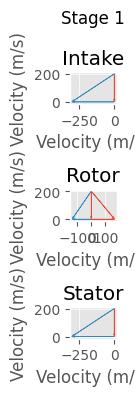

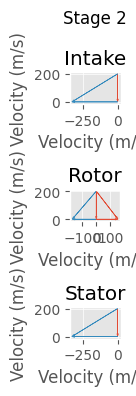

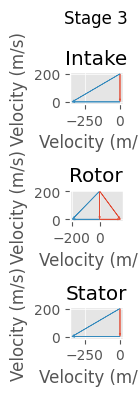

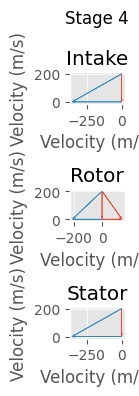

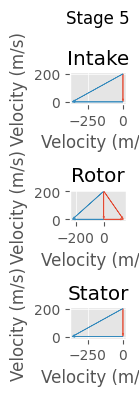

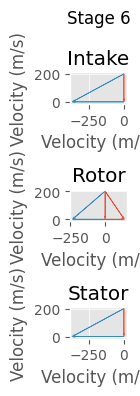

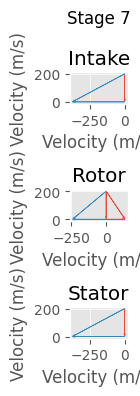

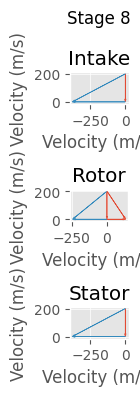

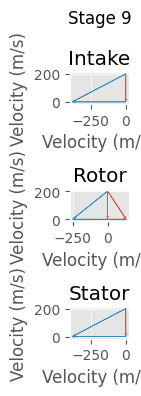

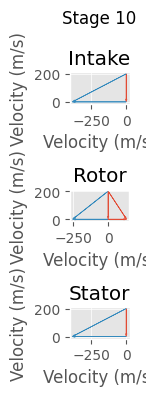

In [391]:
"""
Variables to keep track of:
     0: Total Pressure
     1: Total Temperature
     2: Static Pressure
     3: Static Temperature
     4: Density
     5: Area
     6: Root Radius
     7: Tip Radius
     8: Root Alpha 1
     9: Root Beta 1
    10: Root Alpha 2
    11: Root Beta 2
    12: Root Alpha 3
    13: Root Beta 3
    14: Root de Haller Criterion
    15: Tip Alpha 1
    16: Tip Beta 1
    17: Tip Alpha 2
    18: Tip Beta 2
    19: Tip Alpha 3
    20: Tip Beta 3
    21: Tip de Haller Criterion
"""

label_array = [
    "Total Pressure (kPa)", 
    "Total Temperature (K)", 
    "Static Pressure (kPa)", 
    "Static Temperature (K)", 
    "Density (N/m^3)", 
    "Area (m^2)", 
    "Root Radius (m)", 
    "Tip Radius (m)", 
    "Root Alpha 1 (deg)", 
    "Root Beta 1 (deg)", 
    "Root Alpha 2 (deg)", 
    "Root Beta 2 (deg)", 
    "Root Alpha 3 (deg)", 
    "Root Beta 3 (deg)", 
    "Root de Haller Criterion", 
    "Tip Alpha 1 (deg)", 
    "Tip Beta 1 (deg)", 
    "Tip Alpha 2 (deg)", 
    "Tip Beta 2 (deg)", 
    "Tip Alpha 3 (deg)", 
    "Tip Beta 3 (deg)", 
    "Tip de Haller Criterion"
    ]

decimal_array = [
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.2f}',
    '{:.3f}',
    '{:.3f}',
    '{:.3f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.3f}',    
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.3f}'
]

style_dict = dict(zip(label_array, decimal_array))

variable_array = np.zeros((num_stages, 22))

## Populate initial conditions
initial_conditions = np.array([
    [P_t2],
    [T_t2],
    [P_2],
    [T_2],
    [rho_2],
    [A_c],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')]
    ]).T

variable_array = np.vstack((initial_conditions, variable_array))

delta_T_stage = np.real(delta_T_stage)
variable_array = np.real(variable_array)
index_array = ['Initial Conditions']

for i in range(num_stages):
    index_array.append(f'Stage {i + 1}')

    T_ts = variable_array[i, 1] + delta_T_stage
    P_ts = variable_array[i, 0] * (delta_T_stage/variable_array[i, 1]+1)**((gamma_c*eta_pc)/(gamma_c-1))

    Ps = P_ts - C_a**2/(2*cpa)
    Ts = T_ts - C_a**2/(2*cpa)

    rho_s = Ps/(R*Ts)
    As = mdot_c/(rho_s*C_a)

    h_s = (As*N)/U_m
    r_ts = r_m + (h_s/2)
    r_rs = r_m - (h_s/2)

    U_ts = 2*np.pi*N*r_ts
    U_rs = 2*np.pi*N*r_rs

    alpha_1rs = 0.0
    alpha_2rs = np.arctan((cpa*delta_T_stage)/(U_rs*C_a))
    alpha_3rs = alpha_1rs

    beta_1rs = np.arctan(U_rs/C_a)
    V_1rs = C_a/np.cos(beta_1rs)
    beta_2rs = np.arctan(U_rs/C_a - np.tan(alpha_2rs))
    V_2rs = C_a/np.cos(beta_2rs)
    beta_3rs = beta_1rs

    alpha_1ts = 0.0
    alpha_2ts = np.arctan((cpa*delta_T_stage)/(U_ts*C_a))
    alpha_3ts = alpha_1ts

    beta_1ts = np.arctan(U_ts/C_a)
    V_1ts = C_a/np.cos(beta_1ts)
    beta_2ts = np.arctan(U_ts/C_a - np.tan(alpha_2ts))
    V_2ts = C_a/np.cos(beta_2ts)
    beta_3ts = beta_1ts

    dehaller_rs = V_2rs/V_1rs
    dehaller_ts = V_2ts/V_1ts

    alpha_1rs, alpha_2rs, alpha_3rs, beta_1rs, beta_2rs, beta_3rs = np.array([alpha_1rs, alpha_2rs, alpha_3rs, beta_1rs, beta_2rs, beta_3rs]) * 180/np.pi
    alpha_1ts, alpha_2ts, alpha_3ts, beta_1ts, beta_2ts, beta_3ts = np.array([alpha_1ts, alpha_2ts, alpha_3ts, beta_1ts, beta_2ts, beta_3ts]) * 180/np.pi

    variable_array[i+1, :] =\
         [P_ts, T_ts, Ps, Ts, rho_s, As, r_rs, r_ts, alpha_1rs, beta_1rs, alpha_2rs, beta_2rs, alpha_3rs, beta_3rs, dehaller_rs, alpha_1ts, beta_1ts, alpha_2ts, beta_2ts, alpha_3ts, beta_3ts, dehaller_ts]
    
    alpha_rs_list = [alpha_1rs, alpha_2rs, alpha_3rs]
    beta_rs_list = [beta_1rs, beta_2rs, beta_3rs]

    plot_stage_triangle(f'Stage {i+1}', C_a, alpha_rs_list, beta_rs_list)

# print(np.real(np.round(variable_array)))

print(f'Fan Pressure Ratio: {variable_array[0, 0]/P_a:.1f}')
print(f'Compressor Pressure Ratio: {variable_array[-1, 0]/variable_array[0, 0]:.1f}')
print(f'Total Pressure Ratio: {variable_array[-1, 0]/P_a:.1f}')

variable_array_sf = variable_array.copy()
variable_array_sf[:, 0] = variable_array_sf[:, 0]/1000
variable_array_sf[:, 2] = variable_array_sf[:, 2]/1000

df = pd.DataFrame(variable_array_sf, columns=label_array, index=index_array)
df_styled = df.style.format(style_dict)
display(df_styled)
dfi.export(df_styled, 'Compressor-Table.png')

In [392]:
delta_T0s = w_c/cpg

print(f'Turbine Temperature Drop: {np.round(delta_T0s, 2)} K')

T_t4 = TIT
T_5 = T_t4 - delta_T0s - C_a**2/(2*cpg)
P_t4 = P_t3

T_4 = T_t4 - C_a**2/(2*cpg)
P_4 = P_t4 - C_a**2/(2*cpg)

rho_4 = P_4/(R*T_4)
A_4 = mdot_h/(C_a*rho_4)

Prat_inv = (1 - delta_T0s/T_t4)**(gamma_h/(eta_pt*(gamma_h-1)))
P_t5 = P_t4 * Prat_inv
P_5 = P_t5 - C_a**2/(2*cpg)

rho_5 = P_5/(R*T_5)

A_5 = mdot_h/(rho_5 * C_a)

r_turbt = r_ct
r_turbr = np.sqrt(r_turbt**2 - A_5/np.pi)
r_turbm = (r_turbt + r_turbr)/2

print(f'Turbine Exit Tip Radius {np.round(r_turbt, 4)} m')
print(f'Turbine Exit Mean Radius: {np.round(r_turbm, 4)} m')
print(f'Turbine Exit Root Radius {np.round(r_turbr, 4)} m')

U_tm = 2*np.pi*N*r_turbm
D_T0s = psi_t*U_tm**2/(2*cpg)

t_stages = delta_T0s/D_T0s
t_stages = int(t_stages) if t_stages % 1 == 0 else int(t_stages+1)

print(f'Turbine Stages: {t_stages}')
D_T0s = delta_T0s/t_stages


Turbine Temperature Drop: 439.49 K
Turbine Exit Tip Radius 0.5802 m
Turbine Exit Mean Radius: 0.5596 m
Turbine Exit Root Radius 0.539 m
Turbine Stages: 2


In [393]:
label_array_turb = [
    "Total Pressure (kPa)", 
    "Total Temperature (K)", 
    "Static Pressure (kPa)", 
    "Static Temperature (K)", 
    "Density (N/m^3)", 
    "Area (m^2)", 
    "Root Radius (m)", 
    "Tip Radius (m)", 
    "Root Alpha 1 (deg)", 
    "Root Beta 1 (deg)", 
    "Root Alpha 2 (deg)", 
    "Root Beta 2 (deg)", 
    "Root Alpha 3 (deg)", 
    "Root Beta 3 (deg)", 
    "Tip Alpha 1 (deg)", 
    "Tip Beta 1 (deg)", 
    "Tip Alpha 2 (deg)", 
    "Tip Beta 2 (deg)", 
    "Tip Alpha 3 (deg)", 
    "Tip Beta 3 (deg)", 
    ]

decimal_array_turb = [
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.2f}',
    '{:.3f}',
    '{:.3f}',
    '{:.3f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}',
    '{:.1f}'
]

style_dict_turb = dict(zip(label_array_turb, decimal_array_turb))

variable_array_turb = np.zeros((t_stages, 20))

## Populate initial conditions
initial_conditions_turb = np.array([
    [P_t4],
    [T_t4],
    [P_4],
    [T_4],
    [rho_4],
    [A_4],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')],
    [float('NaN')]
    ]).T

variable_array_turb = np.vstack((initial_conditions_turb, variable_array_turb))

LAMBDA_M = 0.5

index_array_turb = ['Initial Conditions']

for i in range(t_stages):
    index_array_turb.append(f'Stage {i + 1}')

    T_ts = variable_array_turb[i, 1] - D_T0s
    P_ts = variable_array_turb[i, 0] * (1 - D_T0s/variable_array_turb[i, 1])**(gamma_h/(eta_pt*(gamma_h-1)))

    T_s = T_ts - C_a**2/(2*cpg)
    P_s = P_ts - C_a**2/(2*cpg)

    rho_s = P_s/(R * T_s)
    A_s = mdot_h/(rho_s * C_a)

    h_s = A_s*N/U_tm

    r_tts = r_turbm + (h_s/2)
    r_trs = r_turbm - (h_s/2)

    lambda_t = 1 - 1/(r_tts/r_turbm)**2 * (1 - LAMBDA_M)
    lambda_r = 1 - 1/(r_trs/r_turbm)**2 * (1 - LAMBDA_M)

    phi_t = C_a/(2*np.pi*N*r_tts)
    phi_m = C_a/(2*np.pi*N*r_turbm)
    phi_r = C_a/(2*np.pi*N*r_trs)

    # Mean Line
    beta_2_m = np.arctan(1/(2*phi_m)*(psi_t/2-2*LAMBDA_M))
    alpha_2_m = np.arctan(np.tan(beta_2_m)+1/phi_m)
    beta_3_m = np.arctan(1/(2*phi_m)*(psi_t/2+2*LAMBDA_M))
    alpha_3_m = np.arctan(np.tan(beta_3_m)-1/phi_m)
    alpha_1_m = alpha_3_m
    beta_1_m = beta_3_m

    # Tip Line
    beta_2_t = np.arctan(1/(2*phi_t)*(psi_t/2-2*LAMBDA_M))
    alpha_2_t = np.arctan(np.tan(beta_2_m)+1/phi_t)
    beta_3_t = np.arctan(1/(2*phi_t)*(psi_t/2+2*LAMBDA_M))
    alpha_3_t = np.arctan(np.tan(beta_3_m)-1/phi_t)
    beta_1_t = beta_3_t
    alpha_1_t = alpha_3_t

    # Root Line
    beta_2_r = np.arctan(1/(2*phi_r)*(psi_t/2-2*LAMBDA_M))
    alpha_2_r = np.arctan(np.tan(beta_2_m)+1/phi_r)
    beta_3_r = np.arctan(1/(2*phi_r)*(psi_t/2+2*LAMBDA_M))
    alpha_3_r = np.arctan(np.tan(beta_3_m)-1/phi_r)
    beta_1_r = beta_3_r
    alpha_1_r = alpha_3_r

    beta_2_t, alpha_2_t, beta_3_t, alpha_3_t, beta_1_t, alpha_1_t = np.array([beta_2_t, alpha_2_t, beta_3_t, alpha_3_t, beta_1_t, alpha_1_t]) * 180/np.pi
    beta_2_r, alpha_2_r, beta_3_r, alpha_3_r, beta_1_r, alpha_1_r = np.array([beta_2_r, alpha_2_r, beta_3_r, alpha_3_r, beta_1_r, alpha_1_r]) * 180/np.pi

    variable_array_turb[i+1, :] =\
         [P_ts, T_ts, P_s, T_s, rho_s, A_s, r_trs, r_tts, alpha_1_r, beta_1_r, alpha_2_r, beta_2_r, alpha_3_r, beta_3_r, alpha_1_t, beta_1_t, alpha_2_t, beta_2_t, alpha_3_t, beta_3_t]

# print(f'Fan Pressure Ratio: {variable_array[0, 0]/P_a:.1f}')
# print(f'Compressor Pressure Ratio: {variable_array[-1, 0]/variable_array[0, 0]:.1f}')
# print(f'Total Pressure Ratio: {variable_array[-1, 0]/P_a:.1f}')

variable_array_turb_display = variable_array_turb.copy()
variable_array_turb_display[:, 0] = variable_array_turb_display[:, 0]/1000
variable_array_turb_display[:, 2] = variable_array_turb_display[:, 2]/1000

df = pd.DataFrame(variable_array_turb_display, columns=label_array_turb, index=index_array_turb)
df_styled_turbine = df.style.format(style_dict_turb)
display(df_styled_turbine)
dfi.export(df_styled_turbine, 'Turbine-Table.png')

,Total Pressure (kPa),Total Temperature (K),Static Pressure (kPa),Static Temperature (K),Density (N/m^3),Area (m^2),Root Radius (m),Tip Radius (m),Root Alpha 1 (deg),Root Beta 1 (deg),Root Alpha 2 (deg),Root Beta 2 (deg),Root Alpha 3 (deg),Root Beta 3 (deg),Tip Alpha 1 (deg),Tip Beta 1 (deg),Tip Alpha 2 (deg),Tip Beta 2 (deg),Tip Alpha 3 (deg),Tip Beta 3 (deg)
Initial Conditions,2918.2,2150.0,2918.2,2132.6,4.77,0.068,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Stage 1,1834.7,1930.3,1834.7,1912.8,3.34,0.097,0.546,0.573,29.5,68.2,68.3,26.6,29.5,68.2,24.9,69.2,69.1,27.8,24.9,69.2
Stage 2,1090.5,1710.5,1090.5,1693.1,2.24,0.145,0.539,0.580,30.5,68.0,68.2,26.3,30.5,68.0,23.7,69.4,69.3,28.1,23.7,69.4
